## Data 3550 Final Project
### Ayman Boules, Katherine Simon, Nicholas Sartino, Sammi Hamdan

# 1. Import the required packages

In [1]:
# Installs (comment out if you don't need)

# !pip-install missingno
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error

from numpy import arange

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

import statsmodels.api as sm

pd.set_option('display.max_columns',200) #allows for up to 200 columns to be displayed when viewing a dataframe
pd.set_option('display.max_rows',100)
# The following was commented out as it is deprecated and no longer works with current version.
#plt.style.use('seaborn') # a style that can be used for plots - see style reference above

# trick to widen the screen
from IPython.core.display import display, HTML

#Widens the code landscape 
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\krrat\AppData\Local\Temp\ipykernel_10100\581846845.py:32: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Step 1

## Load in the Dataset

In [3]:
df = pd.read_csv('College_Admission_data.csv',index_col=0)

## Data Exploratory Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, Alabama A & M University to Polytechnic University of Puerto Rico-Orlando
Columns: 107 entries, Applicants total to Endowment assets (year end) per FTE enrollment (FASB)
dtypes: float64(97), object(10)
memory usage: 1.3+ MB


In [5]:
df.describe()

,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of first-time undergraduates - foreign countries,Number of first-time undergraduates - residence unknown,Percent of first-time undergraduates - residence unknown,"Graduation rate - Bachelor degree within 4 years, total","Graduation rate - Bachelor degree within 5 

In [6]:
df.head()

,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,State abbreviation,FIPS state code,Geographic region,Sector of institution,Level of institution,Control of institution,Historically Black College or University,Tribal college,Degree of urbanization (Urban-centric locale),Carnegie Classification 2010: Basic,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of firs

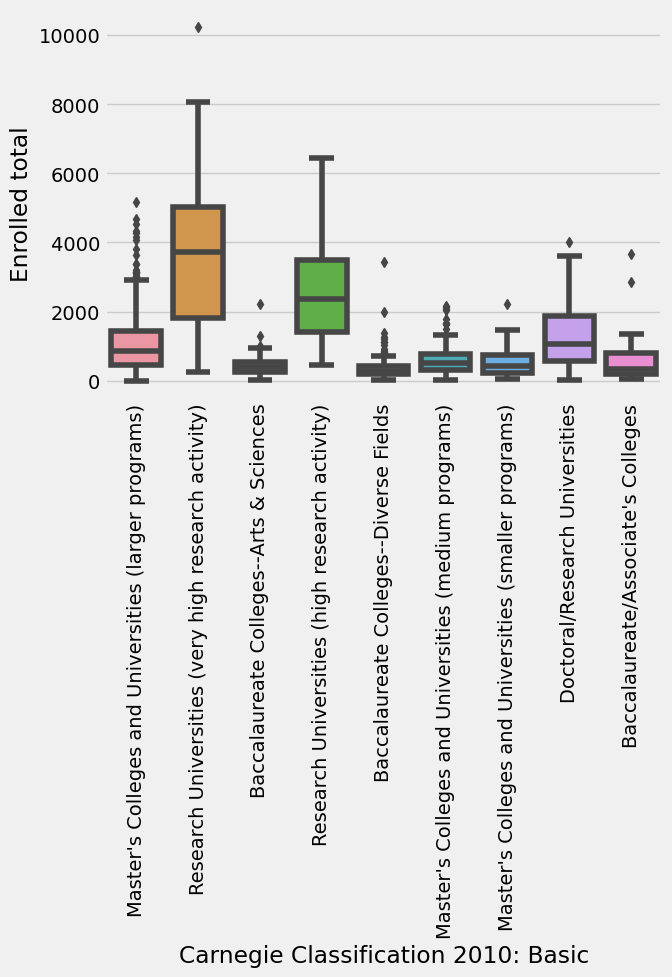

In [7]:
ax = sns.boxplot(x='Carnegie Classification 2010: Basic',y='Enrolled total', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

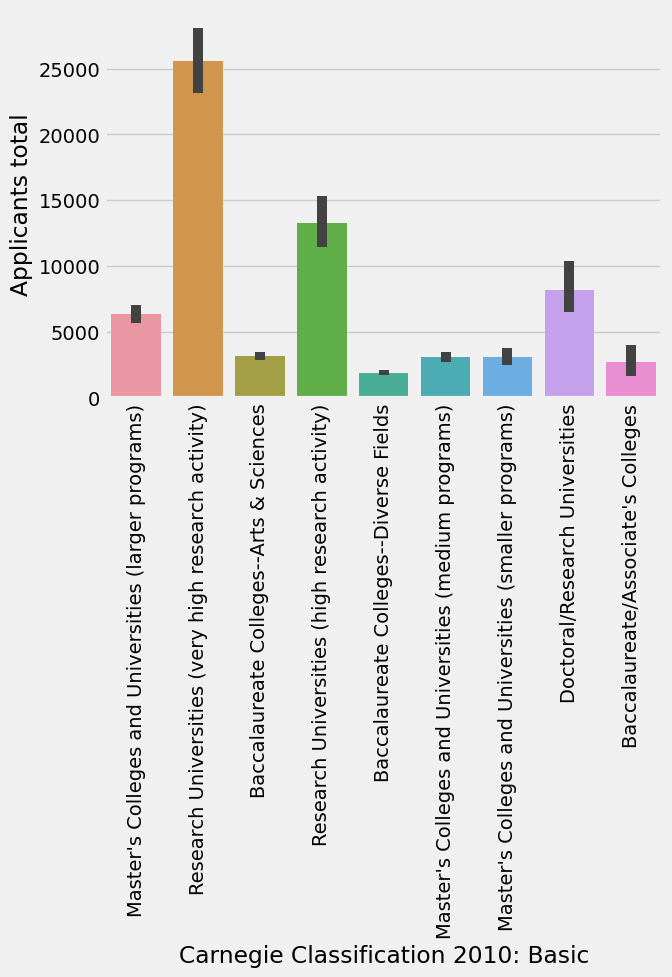

In [8]:
ax = sns.barplot(x='Carnegie Classification 2010: Basic', y='Applicants total', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

## Data Preprocessing

In [9]:
# Splitting the target variable and features
X = df.drop('Carnegie Classification 2010: Basic', axis=1)
y = df['Carnegie Classification 2010: Basic']

In [10]:
# Convert the categorical target variable into a numerical variable.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert the encoded labels back to the original categories
# y = le.inverse_transform(y_encoded)

# Convert categorical features into numerical features.
df_dummies = pd.get_dummies(X, drop_first=True)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, Alabama A & M University to Polytechnic University of Puerto Rico-Orlando
Columns: 219 entries, Applicants total to Degree of urbanization (Urban-centric locale)_Town: Remote
dtypes: bool(122), float64(97)
memory usage: 1.4+ MB


In [11]:
df_dummies.head()

,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of first-time undergraduates - foreign countries,Number of first-time undergraduates - residence unknown,Percent of first-time undergraduates - residence unknown,"Graduation rate - Bachelor degree within 4 years, total","Graduation rate - Bachelor degree within 5 

In [12]:
# Drop unnecessary colums
df.drop(['State abbreviation','FIPS state code','Geographic region'],axis=1,inplace=True)

In [13]:
# Find columns with missing values and their counts
missing_counts = df_dummies.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)

Applicants total                                                                           157
Admissions total                                                                           157
Enrolled total                                                                             157
Percent of freshmen submitting SAT scores                                                  277
Percent of freshmen submitting ACT scores                                                  275
SAT Critical Reading 25th percentile score                                                 365
SAT Critical Reading 75th percentile score                                                 365
SAT Math 25th percentile score                                                             352
SAT Math 75th percentile score                                                             352
SAT Writing 25th percentile score                                                          820
SAT Writing 75th percentile score                 

### Data Imputation
* There are a lot of variables with missing values. Many of them are correlated as well. For example, all of the enrollment variables have exactly 2 missing values.
* The goal in this section will be to try to maintain the representation of the data, which means that no statistical value will be used to fill in an NA.

#### Rules that will be followed:
* columns having at least half of its values being missing values will be dropped.
* columns having a significant number of missing values (>=100) will have its values substituted with the median (assuming a normal distribution).
* columns columns having an insignificant number of missing values will be substituted with appropriate values that indicate that those values were not given.

In [14]:
# Removing columns with a very large amount of missing values

# Threshold
prop = 0.5

# Drop columns with more than 'prop' proportion of missing values
df_filtered = df_dummies.dropna(thresh=int(df_dummies.shape[0] * prop), axis=1)

In [15]:
# Handling columns having a significant number of missing values

# Threshold
min_missing_values = 100

# Go through each column in the DataFrame
for col in df_filtered.columns:
    # If the column has 100 or more missing values
    if df_filtered[col].isna().sum() >= min_missing_values:
        # Fill the missing values with the median of the column
        df_filtered[col].fillna(df_filtered[col].median(), inplace=True)

C:\Users\krrat\AppData\Local\Temp\ipykernel_10100\3442731007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(df_filtered[col].median(), inplace=True)


In [16]:
# Handling columns having an insignificant number of missing values.

# Fill in the rest of the missing values with -1.
df_filtered.fillna(-1, inplace=True)

C:\Users\krrat\AppData\Local\Temp\ipykernel_10100\3803991671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.fillna(-1, inplace=True)


In [17]:
# Find columns with missing values and their counts
missing_counts = df_filtered.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)

Series([], dtype: int64)


### Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered,y_encoded,test_size=0.3,random_state=21)

### Summary of Section
* Categorical variables were converted into numerical variables.
* Missing values were handled according to the rules determined.
* The data was split into training and testing sets.

# Step 2

Run Logisitc Regression.

In [19]:
# Import needed libraries.

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression

In [20]:
# Import Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

#define the scalers
sc = StandardScaler()
mm = MinMaxScaler()
rs = RobustScaler()
nm = Normalizer()

In [21]:
#Standardize the data

sc.fit(X_train)

X_train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns = X_train.columns)

X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns = X_test.columns)

#MinMax scale  the data
mm.fit(X_train)

X_train_mm = mm.transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns = X_train.columns)

X_test_mm = mm.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, columns = X_test.columns)

#Robust scale the data
rs.fit(X_train)

X_train_rs = rs.transform(X_train)
X_train_rs = pd.DataFrame(X_train_rs, columns = X_train.columns)

X_test_rs = rs.transform(X_test)
X_test_rs = pd.DataFrame(X_test_rs, columns = X_test.columns)

#Normalize the data
nm.fit(X_train)

X_train_nm = nm.transform(X_train)
X_train_nm = pd.DataFrame(X_train_nm, columns = X_train.columns)

X_test_nm = nm.transform(X_test)
X_test_nm = pd.DataFrame(X_test_nm, columns = X_test.columns)

In [22]:
# # Use grid search to find the best parameters for the logistic regression model.
# grid={"C":[0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10], "penalty":["l1","l2"],
#      "class_weight": [None, 'balanced', {0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:2.5}, {0:1, 1:3}, {0:1, 1:5}], "solver":['lbfgs', 'liblinear']}
# logreg=LogisticRegression(random_state = 42,max_iter=10000)
# logreg_cv=GridSearchCV(logreg,grid,cv=10)
# logreg_cv.fit(X_train,y_train)

# print("Tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
# print("Accuracy :",logreg_cv.best_score_)

Above grid search took over 5 hours to run. To preserve notebook performance, I'm commenting the code block and pasting the results here.

Result of above:
Tuned hyperparameters :(best parameters)  {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.6001730702665282

The non-scaled data performed better than the scaled data for accuracy.

In [23]:
# Create a function to run the model on given data and print scores.
def modeltraintest(vartrain, vartest, y_train, y_test, model):

    #Fit the model
    model.fit(vartrain, y_train)

    #Predict with the model
    model_pred = model.predict(vartest)
    model_prob = model.predict_proba(vartest)

    print('Confusion Matrix:')
    print(confusion_matrix(y_test, model_pred))
    print("")

    #Assess with the model
    score = model.score(vartest, y_test)
    score_format = 'Accuracy Score: {0:.4f}'.format(score)
    print(score_format)

    recall = recall_score(y_test, model_pred, average='weighted')
    recall_format = 'Recall(Sensitivity) Score: {0:.4f}'.format(recall)
    print(recall_format)
    
    precision = precision_score(y_test, model_pred, average='weighted')
    precision_format = 'Precision(PPV) Score: {0:.4f}'.format(precision)
    print(precision_format)
        
    f1 = f1_score(y_test, model_pred, average='weighted')
    f1_format = 'F1 Score: {0:.4f}'.format(f1)
    print(f1_format)
    
    # calculate roc curve
    # y_pred_prob = model.predict_proba(vartest)[:,1]
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    # roc_auc = roc_auc_score(y_test, y_pred_prob, average='weighted')
    # roc_auc_format = 'ROC AUC Score: {0:.4f}'.format(roc_auc)
    # print(roc_auc_format)
    # print('')

In [24]:
final_model=LogisticRegression(C= 0.5,class_weight= None, penalty= 'l2', solver= 'lbfgs',random_state = 42,max_iter=200000,multi_class='ovr')
final_logreg = final_model.fit(X_train, y_train)

modeltraintest(X_train,X_test,y_train,y_test,final_model)

C:\Users\krrat\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\krrat\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Confusion Matrix:
[[ 52  22   4   2   3   1   1   0   0]
 [  4  57   6   0   8   0   0   0   0]
 [  0   5  12   0   1   1   0   0   0]
 [  0   1   0   2  14   0   0   2   0]
 [  3   3   0   2 100   5   2   2   3]
 [  4   9   0   2  30   5   1   1   0]
 [  1  11   0   0  14   0   2   1   0]
 [  0   0   0   5  14   0   0   6   9]
 [  0   0   0   0   3   0   0   4  21]]

Accuracy Score: 0.5575
Recall(Sensitivity) Score: 0.5575
Precision(PPV) Score: 0.5380
F1 Score: 0.5132


In [25]:
# Try standard scaled data on the model.
vartrain = X_train_sc
vartest = X_test_sc
modeltraintest(vartrain,vartest,y_train,y_test,final_model)

Confusion Matrix:
[[58 17  3  2  2  1  2  0  0]
 [10 52  2  0  4  5  1  1  0]
 [ 1  5 12  0  0  0  1  0  0]
 [ 0  1  0  2 15  0  0  1  0]
 [ 3  9  0  8 78 13  3  5  1]
 [ 4 11  0  0 22 11  4  0  0]
 [ 4  9  0  0  9  6  1  0  0]
 [ 0  1  0  1 14  0  0 13  5]
 [ 0  0  0  0  4  0  0  5 19]]

Accuracy Score: 0.5336
Recall(Sensitivity) Score: 0.5336
Precision(PPV) Score: 0.5111
F1 Score: 0.5151


In [26]:
# Try robust scaled data on the model.
vartrain = X_train_rs
vartest = X_test_rs
modeltraintest(vartrain,vartest,y_train,y_test,final_model)

Confusion Matrix:
[[60 14  3  2  3  2  1  0  0]
 [ 8 54  4  0  4  4  1  0  0]
 [ 0  7 11  0  0  0  1  0  0]
 [ 0  1  0  1 16  0  0  1  0]
 [ 3  7  0  4 86 12  1  6  1]
 [ 1 11  0  0 27  9  3  1  0]
 [ 3 10  0  0 10  6  0  0  0]
 [ 0  0  0  1 17  0  0 11  5]
 [ 0  0  0  0  1  0  0  5 22]]

Accuracy Score: 0.5510
Recall(Sensitivity) Score: 0.5510
Precision(PPV) Score: 0.5111
F1 Score: 0.5212


In [27]:
# Try minmax scaled data on the model.
vartrain = X_train_mm
vartest = X_test_mm
modeltraintest(vartrain,vartest,y_train,y_test,final_model)

Confusion Matrix:
[[58 21  1  0  3  1  1  0  0]
 [ 8 55  1  0  7  3  0  1  0]
 [ 0  7  6  0  5  0  1  0  0]
 [ 0  2  0  1 16  0  0  0  0]
 [ 7 21  0  1 80  3  2  3  3]
 [ 4 18  0  0 23  4  1  2  0]
 [ 6 10  0  0 12  1  0  0  0]
 [ 1  1  0  1 14  0  0  6 11]
 [ 0  0  0  0  4  0  0  2 22]]

Accuracy Score: 0.5033
Recall(Sensitivity) Score: 0.5033
Precision(PPV) Score: 0.4715
F1 Score: 0.4548


In [28]:
# Try normalized data on the model.
vartrain = X_train_nm
vartest = X_test_nm
modeltraintest(vartrain,vartest,y_train,y_test,final_model)

Confusion Matrix:
[[46 37  0  0  2  0  0  0  0]
 [ 7 63  0  0  4  0  0  0  1]
 [ 2 11  0  0  6  0  0  0  0]
 [ 0  7  0  0 11  0  0  0  1]
 [ 4 44  0  0 64  0  0  0  8]
 [ 3 23  0  0 26  0  0  0  0]
 [ 0 20  0  0  9  0  0  0  0]
 [ 3  1  0  0 28  0  0  0  2]
 [ 6  0  0  0  9  0  0  0 13]]

Accuracy Score: 0.4035
Recall(Sensitivity) Score: 0.4035
Precision(PPV) Score: 0.3056
F1 Score: 0.3309


C:\Users\krrat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: ylabel='Feature'>

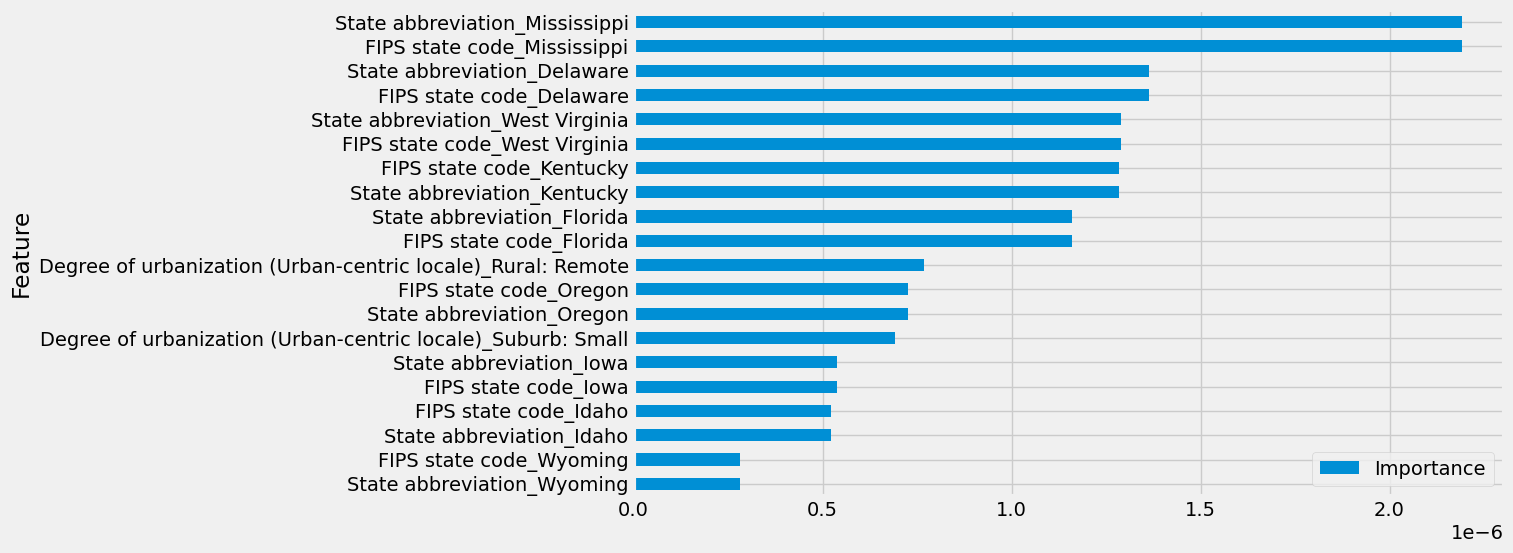

In [29]:
# Find the important features
coefficients = final_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True).head(20)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [30]:
# Get the top 20 features.
top_20 = feature_importance.sort_values('Importance', axis=0, ascending=False).head(20)
top_20 = top_20.index
top_20

Index([117, 167, 100, 150, 141, 191, 160, 110, 102, 152, 209, 180, 130, 212,
       108, 158, 155, 105, 193, 143],
      dtype='int64')

In [31]:
# Select columns based on indices
selected_columns = X_train.iloc[:, top_20]
print(selected_columns)

                                                 State abbreviation_Mississippi  \
Name                                                                              
Pennsylvania State University-Penn State Dubois                           False   
New York Institute of Technology                                          False   
Northeastern Illinois University                                          False   
Antioch University-Los Angeles                                            False   
Middlebury College                                                        False   
...                                                                         ...   
Oakland City University                                                   False   
University of Central Arkansas                                            False   
The College of New Jersey                                                 False   
East Tennessee State University                                           False   
Ohio

In [32]:
# Transform the data to include only important features
X_important_train = X_train.iloc[:, top_20]
X_important_test = X_test.iloc[:, top_20]

In [33]:
# Run the logisitic regression model using the top 20 important features.

modeltraintest(X_important_train,X_important_test,y_train,y_test,final_model)

Confusion Matrix:
[[  0  10   0   0  74   1   0   0   0]
 [  0  13   0   0  62   0   0   0   0]
 [  0   3   0   0  16   0   0   0   0]
 [  0   3   0   0  16   0   0   0   0]
 [  0   7   0   0 110   3   0   0   0]
 [  0   3   0   0  49   0   0   0   0]
 [  0   1   0   0  28   0   0   0   0]
 [  0   2   0   0  30   2   0   0   0]
 [  0   3   0   0  24   1   0   0   0]]

Accuracy Score: 0.2668
Recall(Sensitivity) Score: 0.2668
Precision(PPV) Score: 0.1170
F1 Score: 0.1435


C:\Users\krrat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


limiting to the top 20 most important features resulted in a worse outcome for the logistic regression model.

In [34]:
# Try standard scaled data on the model.
vartrain = X_train_sc
vartest = X_test_sc
modeltraintest(vartrain,vartest,y_train,y_test,final_model)

Confusion Matrix:
[[58 17  3  2  2  1  2  0  0]
 [10 52  2  0  4  5  1  1  0]
 [ 1  5 12  0  0  0  1  0  0]
 [ 0  1  0  2 15  0  0  1  0]
 [ 3  9  0  8 78 13  3  5  1]
 [ 4 11  0  0 22 11  4  0  0]
 [ 4  9  0  0  9  6  1  0  0]
 [ 0  1  0  1 14  0  0 13  5]
 [ 0  0  0  0  4  0  0  5 19]]

Accuracy Score: 0.5336
Recall(Sensitivity) Score: 0.5336
Precision(PPV) Score: 0.5111
F1 Score: 0.5151


In [35]:
# Predict probabilities for each class
y_probs = final_model.predict_proba(X_test_sc)

In [36]:
from sklearn.preprocessing import label_binarize
# Convert labels to one-hot encoding for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8])

# Calculate ROC AUC score for each class
auc_scores = []
for i in range(final_model.classes_.size):
    auc = roc_auc_score(y_test_bin[:, i], y_probs[:, i])
    auc_scores.append(auc)
    print(f"Class {i} ROC AUC Score: {auc:.4f}")

# Average ROC AUC score across all classes
average_auc = sum(auc_scores) / len(auc_scores)
print(f"\nAverage ROC AUC Score: {average_auc:.4f}")

Class 0 ROC AUC Score: 0.9187
Class 1 ROC AUC Score: 0.8571
Class 2 ROC AUC Score: 0.9243
Class 3 ROC AUC Score: 0.7172
Class 4 ROC AUC Score: 0.7863
Class 5 ROC AUC Score: 0.6647
Class 6 ROC AUC Score: 0.6358
Class 7 ROC AUC Score: 0.8618
Class 8 ROC AUC Score: 0.9657

Average ROC AUC Score: 0.8146


In [37]:
# Get list of scores for the Logistic Regression model.
model_pred = final_model.predict(X_test_sc)
logreg_scores = []
logreg_scores.append(final_model.score(X_test_sc, y_test))
logreg_scores.append(recall_score(y_test, model_pred, average='weighted'))
logreg_scores.append(precision_score(y_test, model_pred, average='weighted'))
for i in range(final_model.classes_.size):
    auc = roc_auc_score(y_test_bin[:, i], y_probs[:, i])
    logreg_scores.append(auc)
logreg_scores

[0.5336225596529284,
 0.5336225596529284,
 0.5110878472247619,
 0.9187108886107634,
 0.8570984455958549,
 0.9242676827816146,
 0.7171945701357466,
 0.7862658846529814,
 0.6647075418469062,
 0.6357758620689655,
 0.8617578178812508,
 0.9656878917848896]

In [38]:
# Get coefficients and intercept
coefficients = final_model.coef_
intercept = final_model.intercept_
num_classes = len(final_model.classes_)

# Print the logistic equation
print("Logistic Equation:")

for i in range(num_classes):
    b = 0
    class_equation = f"Class {i}: "
    class_equation += f"{intercept[i]:.4f}"
    for sub in coefficients[i][:]:
        class_equation += f" + ({coefficients[i][b]:.4f} * x{b+1})"
        b += 1
    print(class_equation)

Logistic Equation:
Class 0: -6.9543 + (-0.7168 * x1) + (-0.2361 * x2) + (-0.0141 * x3) + (-0.1669 * x4) + (0.4188 * x5) + (-0.1268 * x6) + (0.8003 * x7) + (-0.4197 * x8) + (-0.0916 * x9) + (0.2517 * x10) + (0.1567 * x11) + (-0.6353 * x12) + (-0.5822 * x13) + (-0.6404 * x14) + (-0.4004 * x15) + (-0.4240 * x16) + (-0.1725 * x17) + (-0.1365 * x18) + (-0.1705 * x19) + (0.3417 * x20) + (-0.8002 * x21) + (-0.8182 * x22) + (-0.7971 * x23) + (-0.3583 * x24) + (0.0073 * x25) + (-0.5408 * x26) + (0.1274 * x27) + (0.2365 * x28) + (0.2357 * x29) + (0.2094 * x30) + (0.1472 * x31) + (0.4043 * x32) + (-0.5910 * x33) + (-0.5240 * x34) + (-0.6447 * x35) + (-0.3408 * x36) + (-1.1630 * x37) + (-0.3723 * x38) + (-0.1028 * x39) + (0.3555 * x40) + (0.3629 * x41) + (0.1240 * x42) + (0.3591 * x43) + (-0.0316 * x44) + (0.2332 * x45) + (0.4597 * x46) + (-0.4041 * x47) + (-0.6715 * x48) + (0.3015 * x49) + (-0.1345 * x50) + (0.1692 * x51) + (-0.3534 * x52) + (0.2882 * x53) + (-0.0020 * x54) + (0.1193 * x55) + (0.

# Step 3

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Drop 'Name' column from X_train and X_test

print(X_train.dtypes)
print(X_test.dtypes)

# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

# If categorical columns are present, encode them using pd.get_dummies()
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)
    
    # Display information about the encoded data
X_train_encoded.info()
X_test_encoded.info()

# Ensure both X_train_encoded and X_test_encoded have the same columns
common_columns = list(set(X_train_encoded.columns) & set(X_test_encoded.columns))
X_train_final = X_train_encoded[common_columns]
X_test_final = X_test_encoded[common_columns]
    

    
    



Applicants total                                                 float64
Admissions total                                                 float64
Enrolled total                                                   float64
Percent of freshmen submitting SAT scores                        float64
Percent of freshmen submitting ACT scores                        float64
                                                                  ...   
Degree of urbanization (Urban-centric locale)_Suburb: Midsize       bool
Degree of urbanization (Urban-centric locale)_Suburb: Small         bool
Degree of urbanization (Urban-centric locale)_Town: Distant         bool
Degree of urbanization (Urban-centric locale)_Town: Fringe          bool
Degree of urbanization (Urban-centric locale)_Town: Remote          bool
Length: 216, dtype: object
Applicants total                                                 float64
Admissions total                                                 float64
Enrolled total          

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_final)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Get a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)



Accuracy: 0.5206
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.58      0.62        85
           1       0.48      0.60      0.54        75
           2       0.87      0.68      0.76        19
           3       0.18      0.32      0.23        19
           4       0.64      0.60      0.62       120
           5       0.21      0.23      0.22        52
           6       0.25      0.14      0.18        29
           7       0.50      0.47      0.48        34
           8       0.77      0.82      0.79        28

    accuracy                           0.52       461
   macro avg       0.51      0.49      0.49       461
weighted avg       0.53      0.52      0.52       461



In [41]:
# Get feature importances from the trained Decision Tree Classifier
feature_importances = clf.feature_importances_

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X_train_final.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
top_n = 10  # Set the number of top features you want to display
top_features = feature_importance_df.head(top_n)
print(top_features)


                                               Feature  Importance
34                                 Graduate enrollment    0.217971
155           Estimated graduate enrollment, full time    0.110153
48   Endowment assets (year end) per FTE enrollment...    0.086990
194  Number of students receiving an Associate's de...    0.040251
114      Percent of graduate enrollment that are women    0.029328
20   Total price for out-of-state students living o...    0.026093
25    Percent of freshmen  receiving federal grant aid    0.025224
112  Graduation rate - Bachelor degree within 4 yea...    0.018095
117                          Tuition and fees, 2011-12    0.017564
87        Percent of freshmen receiving other loan aid    0.016729


Based on the code above, the top ten features deamed important by the Decision Tree Classifier are outputted. It shows that among all the features, the "graduate enrollment" is the most significant feature with a importance value of 0.224.  

Graduate enrollment, total: This feature might have high importance because it could be strongly correlated or indicative of certain types of institutions that fall into specific Carnegie classifications. Institutions with higher graduate enrollment might exhibit characteristics associated with certain categories within the classification.  

Estimated graduate enrollment, full time : This could indicate the graduate enrollment of full time students is strongly correlated or indicative of certain types of institutions.  

Endowment assets per FTE enrollment: Institutions full-time equivalent (FTE) enrollment might belong to a specific category within the Carnegie classification due to financial resources or institutional characteristics associated with these levels of funding.  

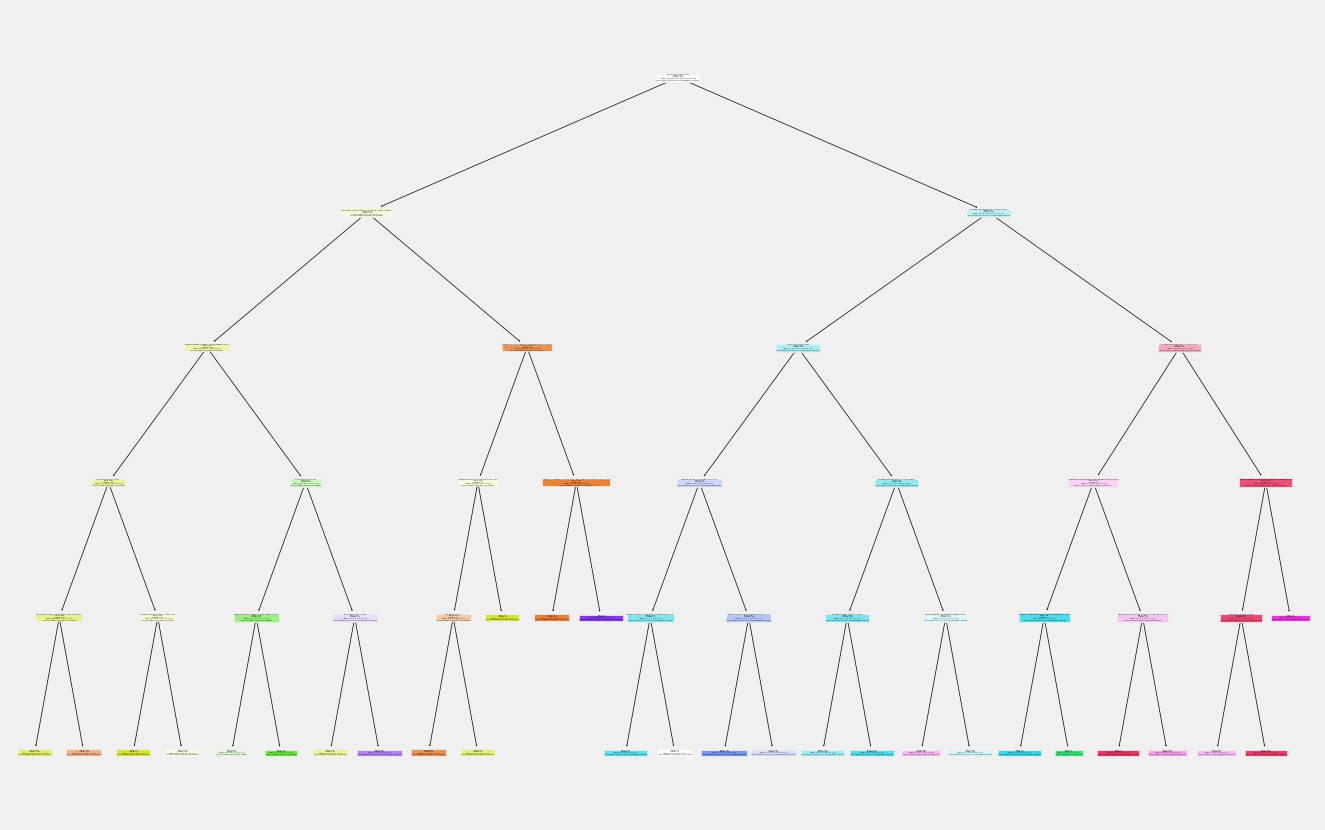

In [42]:
from sklearn.tree import plot_tree


# Fit the Decision Tree Classifier with max_depth=5
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_final, y_train)

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=X_train_final.columns.tolist(), class_names=[str(c) for c in le.classes_])
plt.show()



In [43]:
from sklearn.model_selection import GridSearchCV

# Define a range of depths to search through
param_grid = {'max_depth': range(1, 20)}  # Adjust the range as needed

# Create a GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_final, y_train)

# Get the best estimator and its parameters
dt_best = grid_search.best_estimator_
best_depth = dt_best.get_params()['max_depth']
print(f"Best tree depth: {best_depth}")

# Fit the best model on the entire training data
dt_best.fit(X_train_final, y_train)


Best tree depth: 4


DecisionTreeClassifier(max_depth=4, random_state=42)

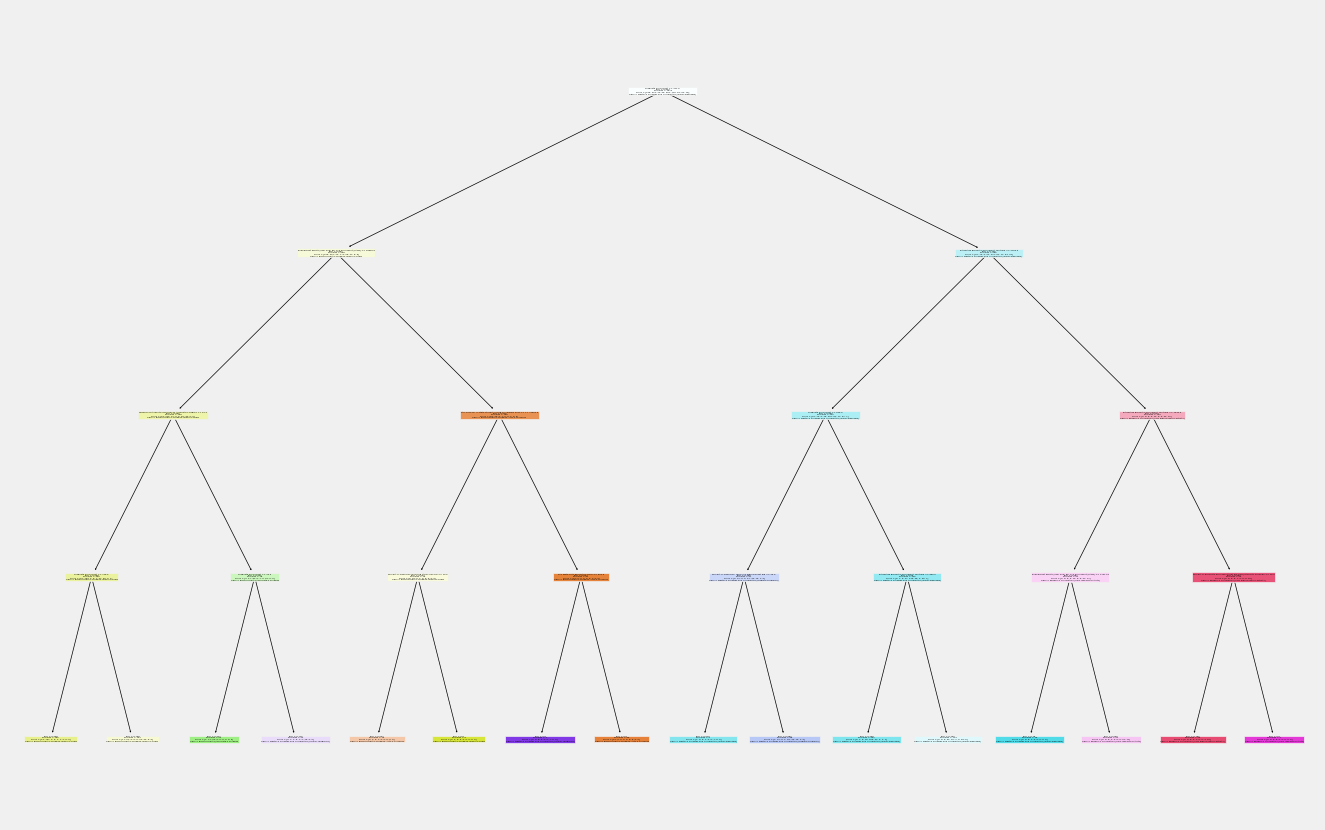

In [44]:
from sklearn.tree import plot_tree

# Plot the final decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_best, filled=True, feature_names=X_train_final.columns.tolist(), class_names=[str(c) for c in le.classes_])
plt.show()


The difference in these 2 DTC plots is the plot depth. During the GridSearchCV process, the model might have found that a smaller or less complex tree performed better on the validation data. Consequently, it prunes or reduces the complexity of the tree to prevent overfitting and improve generalization to unseen data.


In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict on the test set
y_pred = dt_best.predict(X_test_final)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Calculate Sensitivity and Specificity for multiclass classification
# For multiclass, calculating Sensitivity and Specificity directly isn't standard,
# so we'll calculate macro-averaged Sensitivity and Specificity (averaging per class)
TN = conf_matrix.diagonal()[:-1].sum()
FP = conf_matrix[:-1, -1].sum()
FN = conf_matrix[-1, :-1].sum()
TP = conf_matrix[-1, -1]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Macro-averaged Sensitivity: {sensitivity:.4f}")
print(f"Macro-averaged Specificity: {specificity:.4f}")


Accuracy: 0.5640
Confusion Matrix:
[[ 43  34   2   0   1   5   0   0   0]
 [  5  62   4   0   1   1   2   0   0]
 [  0   3  15   0   1   0   0   0   0]
 [  0   0   0   0  13   2   0   3   1]
 [  0   4   0   0 100   8   0   8   0]
 [  1  16   0   0  19  15   1   0   0]
 [  0  15   0   0   5   7   2   0   0]
 [  0   0   0   0  25   0   0   7   2]
 [  0   0   0   0   3   0   0   9  16]]
Macro-averaged Sensitivity: 0.5714
Macro-averaged Specificity: 0.9879


The accuracy of your model is approximately 56.4%, which is the ratio of correctly predicted samples to the total number of samples.  

The Macro-averaged Sensitivity of approximately 60.71% means that, on average, the model correctly identified around 57.14% of the instances for all classes.  

The Macro-averaged Specificity value indicates that, on average, the model correctly identified around 98.79% of the instances that did not belong to a particular class across all classes.



In [48]:
# Setting decision tree scores to unambiguous variable names.
dt_accuracy = accuracy
dt_sensitivity = sensitivity
dt_specificity = specificity

# Step 5:

In [49]:
# Create a table to hold the scores for each model.
classes=[0, 1, 2,3,4,5,6,7,8]
perf_scores = ['Accuracy','Sensitivity','Specificity']
for i in range(len(classes)):
    perf_scores.append(f"Class {i} ROC AUC Score")

# print(perf_scores)

# Initialize table for model scores with Logisitic Regression.
df_scores = pd.DataFrame(logreg_scores,index=perf_scores,columns=['LogisticRegressionScores'])
df_scores['DecisionTreeScores'] = [dt_accuracy,dt_sensitivity,dt_specificity,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
df_scores['RandomForestScores'] = [0.6160520607375272,0.8214285714285714,0.981203007518797,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
print(df_scores)

                       LogisticRegressionScores  DecisionTreeScores  \
Accuracy                               0.533623            0.563991   
Sensitivity                            0.533623            0.571429   
Specificity                            0.511088            0.987854   
Class 0 ROC AUC Score                  0.918711                 NaN   
Class 1 ROC AUC Score                  0.857098                 NaN   
Class 2 ROC AUC Score                  0.924268                 NaN   
Class 3 ROC AUC Score                  0.717195                 NaN   
Class 4 ROC AUC Score                  0.786266                 NaN   
Class 5 ROC AUC Score                  0.664708                 NaN   
Class 6 ROC AUC Score                  0.635776                 NaN   
Class 7 ROC AUC Score                  0.861758                 NaN   
Class 8 ROC AUC Score                  0.965688                 NaN   

                       RandomForestScores  
Accuracy                        

# Step 6: Regression Problem

## Preprocessing For Regression Problem

In [ ]:
df_focused = df.dropna(subset=['Percent admitted - total'])

# Create A regression model to analyze the admission rate based on factors such as the number of applicants, tuition, average SAT and ACT scores, and other relevant metricds we find.

# Admission rate = total admissions / applicants total

X2 = df_focused.drop('Percent admitted - total',axis=1)
y2 = df_focused['Percent admitted - total']

df_dummies = pd.get_dummies(X2, drop_first=True)
df_dummies.info()

# Removing columns with a very large amount of missing values

# Threshold
prop = 0.5

# Drop columns with more than 'prop' proportion of missing values
df_filtered = df_dummies.dropna(thresh=int(df_dummies.shape[0] * prop), axis=1)


# Handling columns having a significant number of missing values

# Threshold
min_missing_values = 100

# Go through each column in the DataFrame
for col in df_filtered.columns:
    # If the column has 100 or more missing values
    if df_filtered[col].isna().sum() >= min_missing_values:
        # Fill the missing values with the median of the column
        df_filtered[col].fillna(df_filtered[col].median(), inplace=True)


# Handling columns having an insignificant number of missing values.

# Fill in the rest of the missing values with -1.
df_filtered.fillna(-1, inplace=True)

# Find columns with missing values and their counts
missing_counts = df_filtered.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)


## Lasso Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered,y2,test_size=0.3,random_state=21)

In [ ]:
df_focused = df.dropna(subset=['Percent admitted - total'])

# Create A regression model to analyze the admission rate based on factors such as the number of applicants, tuition, average SAT and ACT scores, and other relevant metricds we find.

# Admission rate = total admissions / applicants total

X2 = df_focused.drop('Percent admitted - total',axis=1)
y2 = df_focused['Percent admitted - total']

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso() 

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# fit the data i.e calculate the mean and sd of each coluns of X_train
sc.fit(X_train)

#transform the train data
X_train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

#transform the test data
X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the range of lambda (alpha) values you want to test
param_grid = {'alpha': [0.00000000001, 0.00000001,0.0000001, 0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 1000]}

grid_search = GridSearchCV(lasso, param_grid, scoring='neg_mean_squared_error', cv=5)

In [ ]:
# Perform the grid search
grid_search.fit(X_train_sc, y_train)

# Find the best lambda (alpha) value
best_alpha = grid_search.best_params_['alpha']

# Train a Ridge model with the best lambda value
best_lasso_model = Lasso(alpha=best_alpha)
best_lasso_model.fit(X_train_sc, y_train)

In [ ]:
# Calculate the estimated y values using the test dataset
y_hat_test = best_lasso_model.predict(X_test_sc)

In [ ]:
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_hat_test)
test_r_squared = r2_score(y_test, y_hat_test)
test_mape = mean_absolute_percentage_error(y_test, y_hat_test)

print(f'The test RMSE is:\t{round(test_rmse, 3)}')
print(f'The test Rsquared is:\t{round(test_r_squared, 4)}')
print(f'The test MAPE is:\t{round(test_mape, 4)}')

In [ ]:
residuals = [actual - predicted for actual, predicted in zip(y_test, y_hat_test)]
# Create a scatter plot
plt.scatter(y_test, residuals)
plt.xlabel('Percent admitted - total')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Show the plot
plt.show()

## Ridge Regression

In [ ]:
df_focused = df.dropna(subset=['Percent admitted - total'])

# Create A regression model to analyze the admission rate based on factors such as the number of applicants, tuition, average SAT and ACT scores, and other relevant metricds we find.

# Admission rate = total admissions / applicants total

X2 = df_focused.drop('Percent admitted - total',axis=1)
y2 = df_focused['Percent admitted - total']

df_dummies = pd.get_dummies(X2, drop_first=True)
df_dummies.info()

# Removing columns with a very large amount of missing values

# Threshold
prop = 0.5

# Drop columns with more than 'prop' proportion of missing values
df_filtered = df_dummies.dropna(thresh=int(df_dummies.shape[0] * prop), axis=1)


# Handling columns having a significant number of missing values

# Threshold
min_missing_values = 100

# Go through each column in the DataFrame
for col in df_filtered.columns:
    # If the column has 100 or more missing values
    if df_filtered[col].isna().sum() >= min_missing_values:
        # Fill the missing values with the median of the column
        df_filtered[col].fillna(df_filtered[col].median(), inplace=True)


# Handling columns having an insignificant number of missing values.

# Fill in the rest of the missing values with -1.
df_filtered.fillna(-1, inplace=True)

# Find columns with missing values and their counts
missing_counts = df_filtered.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)



In [ ]:
X_train_rid, X_test_rid, y_train_rid, y_test_rid = train_test_split(df_filtered,y2,test_size=0.3,random_state=21)


In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge() 


from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# fit the data i.e calculate the mean and sd of each coluns of X_train
sc.fit(X_train_rid)

#transform the train data
X_train_sc = sc.transform(X_train_rid)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_rid.columns)

#transform the test data
X_test_sc = sc.transform(X_test_rid)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_rid.columns)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define the parameter grid for Ridge regression
param_grid = {'alpha': [0.001,0.1, 1, 10, 100,1000, 10000]} 

# Initialize Ridge regression
ridge = Ridge()

# Perform grid search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(X_train_sc, y_train_rid)

# Find the best lambda (alpha) value
best_alpha = grid_search.best_params_['alpha']

# Train a Ridge model with the best lambda value
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train_sc, y_train_rid)


In [ ]:
# Calculate the estimated y values using the test dataset
y_hat_test = best_ridge_model.predict(X_test_sc)

In [ ]:
test_mse = mean_squared_error(y_test_rid, y_hat_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_rid, y_hat_test)
test_r_squared = r2_score(y_test_rid, y_hat_test)
test_mape = mean_absolute_percentage_error(y_test_rid, y_hat_test)

print(f'The test RMSE is:\t{round(test_rmse, 3)}')
print(f'The test Rsquared is:\t{round(test_r_squared, 4)}')
print(f'The test MAPE is:\t{round(test_mape, 4)}')

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test_rid - y_hat_test

# Create a residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_hat_test, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot for Ridge Regression')
plt.xlabel('Percent Admitted - Total')
plt.ylabel('Residuals')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler


param_grid = {
    'alpha': [0.0000001,0.001,0.1, 1, 10, 100,],
    'kernel': ['poly','laplacian', 'rbf', 'sigmoid'],
    'gamma': [0.0000001, 1,5, 10, 15]  
}

# Standardize your features if needed
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_rid)  # Assuming X_train is your feature matrix

# Initialize Kernel Ridge regression
krr = KernelRidge()

# Perform grid search
grid_search = GridSearchCV(estimator=krr, param_grid=param_grid)
grid_search.fit(X_train_sc, y_train_rid)

# Find the best parameters
best_params = grid_search.best_params_

# Train a Kernel Ridge model with the best parameters
best_krr_model = KernelRidge(**best_params)
best_krr_model.fit(X_train_sc, y_train_rid)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Assuming you have a test dataset X_test and y_test
X_test_sc = scaler.transform(X_test_rid)  # Scale the test features

# Make predictions using the best Kernel Ridge model
y_pred = best_krr_model.predict(X_test_sc)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_rid, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared (R2)
r2 = r2_score(y_test_rid, y_pred)
print(f"R-squared (R2): {r2}")


cv_scores = cross_val_score(best_krr_model, X_train_sc, y_train_rid, cv=5, scoring='r2')
print("Cross-Validation R-squared scores:", cv_scores)
print(f"Mean Cross-Validation R-squared: {cv_scores.mean()}")
